In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.notebook_tools.ntbk_tools import (print_tensions, rendering_results,
                                                     rendering_convergence_results, create_organo)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
nb_cells = 10
r_in = 110
r_out = 150

In [3]:
seed = 1553
sym_organo = create_organo(seed, 10, 110, 150)

Reseting datasets values with new specs


In [4]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*sym_organo.Nf),[1000]*(3*sym_organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

Solving time: 1.0246280000000003
Distance from th organo to exp organo : 3.4871141898942435
Distance from th tensions to exp tensions : 0.10446195280738077


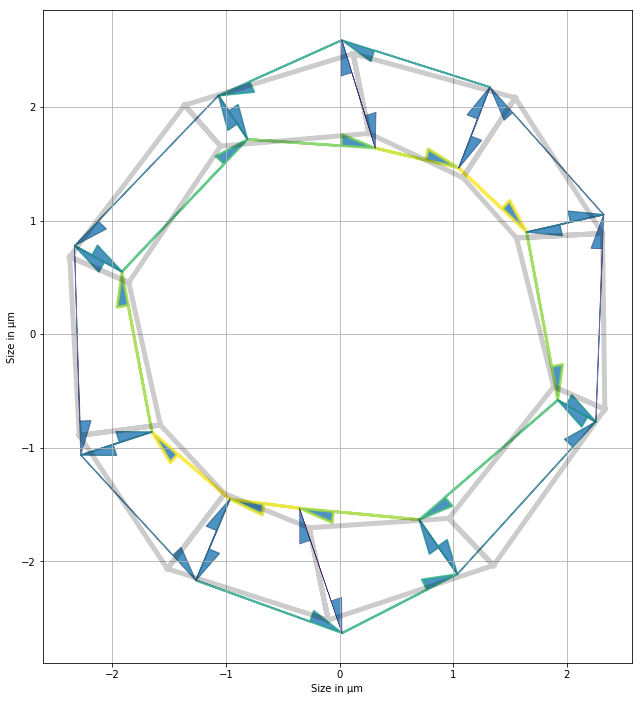

In [5]:
initial_guess = infer_forces(sym_organo, 'NNLS', sup_param='')
start = time.clock()
tensions_sym_organo = sym_organo.copy()
tensions_sym_organo.edge_df.line_tension = prepare_tensions(tensions_sym_organo,
                                                            initial_guess['tensions'])
#print('Energy before optimization: ', model.compute_energy(tensions_sym_organo, False))
Solver.find_energy_min(tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(tensions_sym_organo, False))
print_tensions(tensions_sym_organo, sym_organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] - initial_guess['tensions']))))

In [7]:
iprint_file = "../assets/dist_at_each_f_ev/test_parameters_adjust_tensions.txt"
res_sym_tensions = adjust_tensions(sym_organo, initial_guess['tensions'], 
                                   {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                   energy_opt, iprint_file=iprint_file, **lm_opt)
opt_tensions_sym_organo = sym_organo.copy()
opt_tensions_sym_organo.edge_df.line_tension = prepare_tensions(opt_tensions_sym_organo, res_sym_tensions.x)
Solver.find_energy_min(opt_tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_tensions_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, opt_tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                opt_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))))

KeyboardInterrupt: 

{'method': 'lm', 'xtol': 1e-05, 'ftol': 0.001, 'verbose': 1}
I know I do LM
`xtol` termination condition is satisfied.
Function evaluations 413, initial cost 1.0633e+00, final cost 1.2669e-02, first-order optimality 3.36e+01.
Solving time: 493.540838
Distance from th sym_organo to exp sym_organo : 0.6333639742358187
Distance from th tensions to exp tensions : 0.13927432782939309


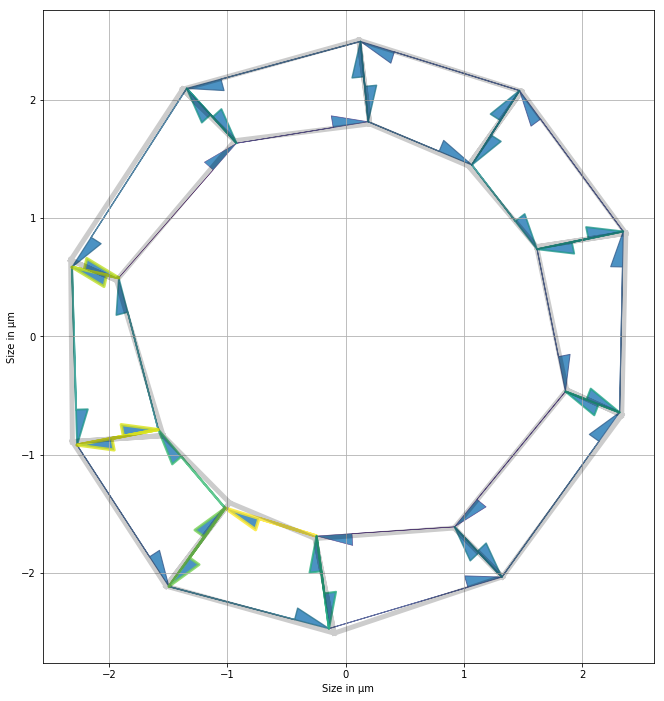

In [6]:
iprint_file = "../assets/dist_at_each_f_ev/test_parameters_adjust_parameters_tensions.txt"
res_sym_tensions = adjust_parameters(sym_organo, initial_guess['tensions'],
                                     {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                     parameters=[('edge', 'line_tension')],
                                     energy_min_opt=energy_opt, iprint_file=iprint_file, **lm_opt)
opt_tensions_sym_organo = sym_organo.copy()
opt_tensions_sym_organo.edge_df.line_tension = prepare_tensions(opt_tensions_sym_organo, res_sym_tensions.x)
Solver.find_energy_min(opt_tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_tensions_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, opt_tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                opt_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))))

{'method': 'lm', 'xtol': 1e-05, 'ftol': 0.001, 'verbose': 1}
I know I do LM
[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([4.90689739e-02, 4.12943628e-02, 7.16761537e-02, 6.88415221e-02,
       4.00441318e-02, 4.49055860e-02, 4.02290610e-02, 6.08817886e-02,
       6.93640133e-02, 3.98020707e-02, 4.74619512e-03, 4.16740980e-03,
       1.49011612e-08, 6.47671871e-03, 1.09154538e-03, 4.49930779e-04,
       2.19030999e-03, 0.00000000e+00, 6.07136105e-03, 2.32330035e-03,
       2.49787728e-02, 2.17080972e-02, 2.43544724e-02, 4.42114336e-02,
       2.69476034e-02, 1.27462872e-02, 1.52594136e-02, 1.66134660e-02,
       3.43205248e-02, 2.51677104e-02, 2.17080972e-02, 2.43544724e-02,
       4.42114336e-02, 2.69476034e-02, 1.27462872e-02, 1.52594136e-02,
       1.66134660e-02, 3.43205248e-02, 2.51677104e-02, 2.49787728e-02]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([4.90689739e-02, 4.12943628e-02, 7.16761537e-02, 6.88415221e-02,
       4.00441318e-02, 4.49055860e-02, 4.02290610e-0

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 , 0.02435447, 0.04421143, 0.0269476 ,
       0.01274629, 0.01525941, 0.01661347, 0.03432052, 0.02516771,
       0.0217081 , 0.02435447, 0.04421143, 0.0269476 , 0.01274629,
       0.01525941, 0.01661347, 0.03432052, 0.02516771, 0.02497877]), array([0.02546284, 0.        , 0.03962185, 0.03740801, 0.        ,
       0.01495616, 0.        , 0.02576051, 0.03737354, 0.        ,
       0.1180824 ])]
[array([0.04906897, 0.04129436, 0.07167615, 0.06884152, 0.04004413,
       0.04490559, 0.04022906, 0.06088179, 0.06936401, 0.03980207,
       0.0047462 , 0.00416741, 0.        , 0.00647672, 0.00109155,
       0.00044993, 0.00219031, 0.        , 0.00607136, 0.0023233 ,
       0.02497877, 0.0217081 

[40 50]
[array([ 4.90851973e-02,  4.12943628e-02,  7.16761537e-02,  6.88415221e-02,
        4.00441318e-02,  4.49055860e-02,  4.02293843e-02,  6.13266287e-02,
        6.93640133e-02,  3.98020707e-02,  4.74619512e-03,  4.16740980e-03,
       -1.40097496e-05,  1.02667661e+00,  1.09154538e-03,  4.49930779e-04,
        2.19030999e-03, -5.27018385e-05,  6.07136105e-03,  2.25838375e-01,
        2.51624093e-01,  2.17080972e-02, -6.14225943e-02,  4.44439931e-02,
        4.37058451e-01, -9.30572877e-02, -8.11650200e-02,  1.66120132e-02,
        3.43170828e-02,  2.51713777e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.54628449e-02, -4.02480694e-05,  3.96218543e-02,  3.74080127e-02,
        2.77041011e-05,  1.49561613e-02,  2.71990175e-05,  2.57605059e-02,
        3.73735402e-02,  0.00000000e+00,  1.16568111e-01])]
[array([ 4.90851973e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965592e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513083e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573906e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236206e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480825e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804249e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465598e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709781e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603030e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298279e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917743e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760507e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461411e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124318e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725415e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544728e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476038e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594138e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205253e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787732e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658911e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472579e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167855e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372950e-02,
        4.76914801e-02,  3.09562702e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 4.92193755e-02,  4.18965586e-02,  7.83615669e-02,  8.09513071e-02,
        2.29476598e-02,  6.65573896e-02,  4.02316737e-02,  5.98236197e-02,
        7.75177056e-02,  2.67480821e-02, -1.84788992e-02,  1.33804247e-02,
       -1.75791976e-05,  6.35465588e-02,  1.67422870e-02,  6.63709771e-03,
        1.52413789e-02, -4.80603037e-05,  7.32082016e-03, -2.82298283e-02,
        9.19845729e-03, -1.17917745e-02,  6.38192695e-02,  4.48760501e-02,
        1.81492096e-02, -1.42461413e-02, -3.28211235e-02,  1.66124316e-02,
        3.43135061e-02,  2.51725411e-02,  2.17080972e-02,  2.43544724e-02,
        4.42114336e-02,  2.69476034e-02,  1.27462872e-02,  1.52594136e-02,
        1.66134660e-02,  3.43205248e-02,  2.51677104e-02,  2.49787728e-02]), array([ 2.63501833e-02, -3.32658916e-05,  1.28997946e-02,  3.82472573e-02,
        2.63273831e-05,  2.61167851e-02,  4.41318927e-06,  1.41372948e-02,
        4.76914801e-02,  3.09562706e-02,  1.18003817e-01])]
[array([ 4.92193755e-02,  4.1

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268124,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268124,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.01025365, -0.00448866,  0.00268021, -0.02606576,
        0.01084542, -0.00900712,  0.05994833,  0.02765114,  0.0215977 ,
       -0.00739422, -0.02190723,  0.01672626,  0.04153646,  0.02720558,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.02975916, -0.00518927,  0.01221272,  0.04245959, -0.01161818,
        0.01129692,  0.00632491,  0.01970117,  0.05302401,  0.04358236,
        0.1399522 ])]
[array([ 0.05416987,  0.03912545,  0.10133585,  0.07251642,  0.02552567,
        0.04689738,  0.02399083,  0.05124438,  0.07268123,  0.01309738,
       -0.01247917,  0.01712086, -0.00579792,  0.08050674,  0.01498521,
        0.00800093,  0.0102536

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432053,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.00662171, -0.00489098,  0.00340619, -0.01737741,
        0.00431688, -0.00620932,  0.06511198,  0.02440654,  0.02451677,
       -0.00536616, -0.01460554,  0.01143853,  0.04228033,  0.02278864,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03703213, -0.0072427 ,  0.00914085,  0.04720814, -0.01264208,
        0.01184088,  0.00172857,  0.02064433,  0.0524228 ,  0.03794282,
        0.1331486 ])]
[array([ 0.05491758,  0.03526436,  0.10135436,  0.06931177,  0.02663122,
        0.04489738,  0.02882108,  0.0452449 ,  0.06251128,  0.02672911,
       -0.00834047,  0.01741579, -0.00489406,  0.0728294 ,  0.01729901,
        0.01040246,  0.0066217

[40 50]
[array([ 0.05584936,  0.03541893,  0.10105111,  0.06980301,  0.02635003,
        0.0443801 ,  0.02855881,  0.04433285,  0.06151163,  0.02698544,
       -0.00858721,  0.01773798, -0.00596359,  0.07230611,  0.01792077,
        0.01060135,  0.00694193, -0.00503526,  0.0038666 , -0.01370539,
        0.0042307 , -0.00676302,  0.06516587,  0.0231855 ,  0.02138886,
       -0.00522862, -0.01211925,  0.01178521,  0.04294166,  0.02187084,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03860032, -0.0069691 ,  0.0089919 ,  0.04674615, -0.01367592,
        0.0107594 ,  0.00191962,  0.02055971,  0.04967287,  0.03888205,
        0.13261364])]
[array([ 0.05584936,  0.03541893,  0.10105111,  0.06980301,  0.02635003,
        0.0443801 ,  0.02855881,  0.04433285,  0.06151163,  0.02698544,
       -0.00858721,  0.01773798, -0.00596359,  0.07230611,  0.01792077,
        0.01060135,  0.0069419

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132445,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132445,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05501171,  0.03524685,  0.10132627,  0.06937575,  0.02658315,
        0.04482759,  0.02881529,  0.04514318,  0.06236097,  0.02676282,
       -0.00839111,  0.01744126, -0.00504356,  0.0727662 ,  0.01741281,
        0.01042902,  0.0066407 , -0.0049003 ,  0.00347184, -0.01682281,
        0.00431219, -0.0062974 ,  0.06511477,  0.02426562,  0.02415933,
       -0.00534509, -0.01437229,  0.01145996,  0.04235637,  0.02266207,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03723177, -0.0071846 ,  0.00910455,  0.04713775, -0.01279609,
        0.01169804,  0.00176342,  0.02060935,  0.05209168,  0.03805137,
        0.13308849])]
[array([ 0.05501171,  0.03524685,  0.10132627,  0.06937575,  0.02658315,
        0.04482759,  0.02881529,  0.04514318,  0.06236097,  0.02676282,
       -0.00839111,  0.01744126, -0.00504356,  0.0727662 ,  0.01741281,
        0.01042902,  0.0066407

[40 50]
[array([ 0.05502129,  0.03527439,  0.10132467,  0.06937954,  0.02659542,
        0.04483228,  0.02880941,  0.04514639,  0.06237637,  0.02676141,
       -0.00838773,  0.01746178, -0.00504248,  0.07276904,  0.01740334,
        0.01042138,  0.006645  , -0.00490582,  0.00347083, -0.01688393,
        0.00430899, -0.00628959,  0.06511525,  0.02426428,  0.02414003,
       -0.00534769, -0.01437486,  0.01145406,  0.04235364,  0.0226804 ,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03723018, -0.00716992,  0.00911602,  0.04715064, -0.01279167,
        0.01171305,  0.00175912,  0.02062828,  0.05210112,  0.03805223,
        0.13309144])]
[array([ 0.05502129,  0.03527439,  0.10132467,  0.06937954,  0.02659542,
        0.04483228,  0.02880941,  0.04514639,  0.06237637,  0.02676141,
       -0.00838773,  0.01746178, -0.00504248,  0.07276904,  0.01740334,
        0.01042138,  0.006645 

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527227,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527227,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.1013305 ,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.1013305 ,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659111,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659111,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483901,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483901,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514079,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514079,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06238463,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06238463,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.0083933 ,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.0083933 ,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.0174708 , -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.0174708 , -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276338,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276338,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740806,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740806,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.00663955, -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066395

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490054,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.01689875,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00431459, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06510926,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.02427016,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00535411, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01436917,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04234716,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268906,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02434842,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421749,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274023,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01526547,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03431447,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02517377,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.0372239 , -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716175,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04714642, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01278496,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.00175244,  0.02063095,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063701,  0.05210247,  0.03805236,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03804631,
        0.13309187])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

[40 50]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456 , -0.00490659,  0.00347069, -0.0168927 ,
        0.00430854, -0.00628849,  0.06511532,  0.0242641 ,  0.02413725,
       -0.00534805, -0.01437523,  0.01145322,  0.04235322,  0.02268301,
        0.0217081 ,  0.02435447,  0.04421143,  0.0269476 ,  0.01274629,
        0.01525941,  0.01661347,  0.03432052,  0.02516771,  0.02497877]), array([ 0.03722996, -0.00716781,  0.00911765,  0.04715248, -0.01279102,
        0.01171524,  0.0017585 ,  0.02063095,  0.05210247,  0.03805236,
        0.13309793])]
[array([ 0.05502265,  0.03527833,  0.10132444,  0.06938007,  0.02659716,
        0.04483296,  0.02880858,  0.04514685,  0.06237858,  0.0267612 ,
       -0.00838725,  0.01746475, -0.00504234,  0.07276943,  0.01740201,
        0.01042028,  0.0066456

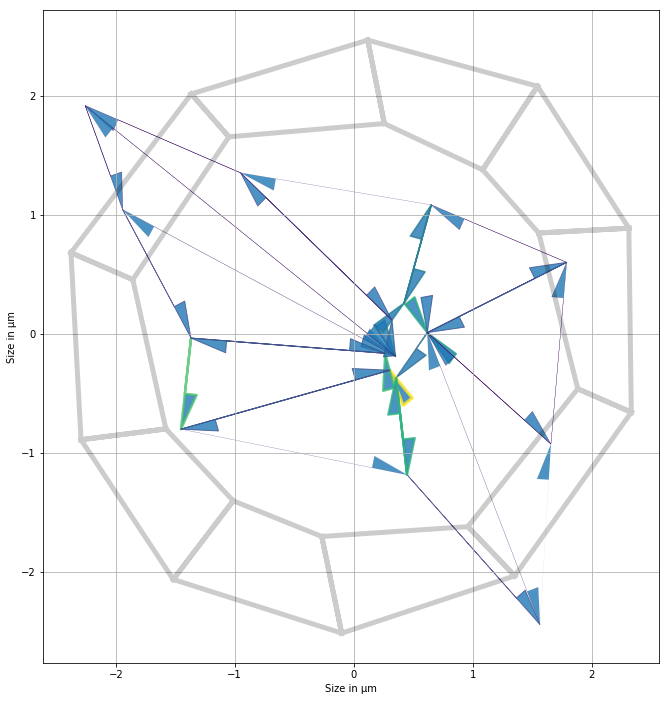

In [22]:
initial_guess = infer_forces(sym_organo, 'NNLS', sup_param='areas')
iprint_file = "../assets/dist_at_each_f_ev/test_parameters_adjust_parameters_tensions_areas.txt"
res_sym_tensions = adjust_parameters(sym_organo, np.concatenate((prepare_tensions(sym_organo, initial_guess['tensions']),
                                                                 initial_guess['areas'])),
                                     {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                     parameters=[('edge', 'line_tension'),
                                                 ('face', 'prefered_area')],
                                     energy_min_opt=energy_opt, iprint_file=iprint_file, **lm_opt)
opt_tensions_sym_organo = sym_organo.copy()
opt_tensions_sym_organo.edge_df.line_tension = prepare_tensions(opt_tensions_sym_organo, res_sym_tensions.x)
Solver.find_energy_min(opt_tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_tensions_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, opt_tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                opt_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))))